# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## Inicialización

In [2]:
# Cargar todas las librerías
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
from scipy import stats as st 
import seaborn as sns
import math 



## Cargar datos

In [8]:
# Carga los archivos de datos en diferentes DataFrames
df_calls = pd.read_csv('C:/Users/andre/Documents/TRIPLETEN ANALISIS DE DATOS/Proyectos/Proyecto_3/megaline_calls.csv')#carga la tabla de llamadas
df_internet=pd.read_csv('C:/Users/andre/Documents/TRIPLETEN ANALISIS DE DATOS/Proyectos/Proyecto_3/megaline_internet.csv')# carga la tabla de internet
df_messages=pd.read_csv('C:/Users/andre/Documents/TRIPLETEN ANALISIS DE DATOS/Proyectos/Proyecto_3/megaline_messages.csv')# carga la tabla de mensajes
df_plans=pd.read_csv('C:/Users/andre/Documents/TRIPLETEN ANALISIS DE DATOS/Proyectos/Proyecto_3/megaline_plans.csv')#carga la tabla de planes
df_users=pd.read_csv('C:/Users/andre/Documents/TRIPLETEN ANALISIS DE DATOS/Proyectos/Proyecto_3/megaline_users.csv')#carga la tabla de usuarios 



## Preparar los datos


Se hizo la revision de todas las tablas , todas estan correctas , una pequena observacion que en todas las tablas el user_id esta como un tipo de dato entero y este deberia ser de tipo objeto ya que es un identificador y no un numero en el cual se realizaran operaciones. De igual manera en la tabla de usuarios se encuentra en churn_date algunos valores ausentes. 

## Tarifas

In [3]:
# Se imprime la información general/resumida sobre el DataFrame de las tarifas
df_plans.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [4]:
# Se imprime una muestra de los datos para las tarifas
df_plans


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate



En este caso en un comienzo se establece que se va a trabjar por minutos como unidad de tiempo , y en GB con respecto al plan , se tiene una columna que indica mb por mes , pero se lo va a transformar a gb para tener la informacion bien. 

## Corregir datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [5]:
#se cammbia el nombre de la columna a por GB
df_plans.rename(columns={'mb_per_month_included':'gb_per_month_included'},inplace=True)
#se tiene la columna con los gbs correspondientes en este caso se observa que existen con 15 gb y con 30 gb
df_plans['gb_per_month_included']=df_plans['gb_per_month_included']/1024
df_plans

,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15.0,500,20,10,0.03,0.03,surf
1,1000,30.0,3000,70,7,0.01,0.01,ultimate


## Usuarios/as

In [6]:
# Se imprime la información general/resumida sobre el DataFrame de usuarios
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [7]:
# Se imprime una muestra de datos para usuarios
df_users


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN
...,...,...,...,...,...,...,...,...
495,1495,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-04,surf,NaN
496,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,NaN
497,1497,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-12-10,ultimate,NaN
498,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,NaN



En este caso se puede ver que los datos de churn_date tiene alguns valores nulos y de igual panera el reg_date tiene en su formato de objeto , hay que transformarlo a de tipo date-time.

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [8]:
#Se transforma el tipo de dato a datetime
df_users['reg_date']=pd.to_datetime(df_users['reg_date'],format='%Y-%m-%d')
#La columna de churn date tenia valores ausentes que representaban que los usuarios seguian usando las lineas,
#por eso se rellenaron esos valores con Activo.
df_users['churn_date'].fillna('Activo',inplace=True)


## Llamadas

In [9]:
# Se imprime la información general/resumida sobre el DataFrame de las llamadas
df_calls.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [10]:
# Se imprime una muestra de datos para las llamadas
df_calls


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22
...,...,...,...,...
137730,1499_199,1499,2018-11-21,8.72
137731,1499_200,1499,2018-10-20,10.89
137732,1499_201,1499,2018-09-21,8.12
137733,1499_202,1499,2018-10-10,0.37



En este caso la fecha nuevamente esta en un formato de objeto el cual se necesita cambiar a un formato de fecha. Los demas datos estan bien. 

### Corregir los datos

In [41]:
df_calls['call_date']=pd.to_datetime(df_calls['call_date'],format='%Y-%m-%d')
#Se redondea al minuto mas cercano de la llamada.
df_calls['duration']=np.ceil(df_calls['duration'])
df_calls

,id,user_id,call_date,duration,year_month
0,1000_93,1000,2018-12-27,9.0,2018-12
1,1000_145,1000,2018-12-27,14.0,2018-12
2,1000_247,1000,2018-12-27,15.0,2018-12
3,1000_309,1000,2018-12-28,6.0,2018-12
4,1000_380,1000,2018-12-30,5.0,2018-12
...,...,...,...,...,...
137730,1499_199,1499,2018-11-21,9.0,2018-11
137731,1499_200,1499,2018-10-20,11.0,2018-10
137732,1499_201,1499,2018-09-21,9.0,2018-09
137733,1499_202,1499,2018-10-10,1.0,2018-10


En este caso para las llamadas 0 pueden significar multiples factores ,errores de registro , datos incompletos , o llamadas no realizadas.

## Mensajes

In [12]:
# Se imprime la información general/resumida sobre el DataFrame de los mensajes
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [13]:
# Imprime una muestra de datos para los mensajes
df_messages

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26
...,...,...,...
76046,1497_526,1497,2018-12-24
76047,1497_536,1497,2018-12-24
76048,1497_547,1497,2018-12-31
76049,1497_558,1497,2018-12-24



El message_date tiene un formato erroneo , el cual se procedera a cambiarlo para dejarlo en un formato de fecha adecuado.

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [14]:
df_messages['message_date']=pd.to_datetime(df_messages['message_date'],format='%Y-%m-%d')
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


## Internet

In [15]:
# Se imprime la información general/resumida sobre el DataFrame de internet
df_internet.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [16]:
# Se imprime una muestra de datos para el tráfico de internet
df_internet


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22
...,...,...,...,...
104820,1499_215,1499,2018-10-20,218.06
104821,1499_216,1499,2018-12-30,304.72
104822,1499_217,1499,2018-09-22,292.75
104823,1499_218,1499,2018-12-07,0.00



Este caso se va a cambiar el formato de session date a un formato de fecha y ademas se va a cambiar el mb_used a gb_used al igual que todos los valores correspondientes a esta columna. 

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [17]:
#Se le cambia el nombre  a la columna de mb por gb
df_internet.rename(columns={'mb_used':'gb_used'},inplace=True )
#Se cambian los valores de mb por gb 
df_internet['gb_used']=np.ceil(df_internet['gb_used']/1024)
#se cambia el formato de fecha  
df_internet['session_date']=pd.to_datetime(df_internet['session_date'],format='%Y-%m-%d')
df_internet

,id,user_id,session_date,gb_used
0,1000_13,1000,2018-12-29,1.0
1,1000_204,1000,2018-12-31,0.0
2,1000_379,1000,2018-12-28,1.0
3,1000_413,1000,2018-12-26,1.0
4,1000_442,1000,2018-12-27,1.0
...,...,...,...,...
104820,1499_215,1499,2018-10-20,1.0
104821,1499_216,1499,2018-12-30,1.0
104822,1499_217,1499,2018-09-22,1.0
104823,1499_218,1499,2018-12-07,0.0


## Estudiar las condiciones de las tarifas

[Es sumamente importante entender cómo funcionan las tarifas, cómo se les cobra a los usuarios en función de su plan de suscripción. Así que te sugerimos imprimir la información de la tarifa para ver una vez más sus condiciones.]

In [18]:
# Se mprime las condiciones de la tarifa para tenerlas clara para el analisis.
df_plans



,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15.0,500,20,10,0.03,0.03,surf
1,1000,30.0,3000,70,7,0.01,0.01,ultimate


## Agregar datos por usuario

[Ahora que los datos están limpios, se agrega los datos por usuario y por periodo para que solo haya un registro por usuario y por periodo. Esto facilitará mucho el análisis posterior.]

In [19]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
#vamos a crear una nueva columna donde solo almacenaremos el mes 
df_calls['year_month'] = df_calls['call_date'].dt.to_period('M')
#agrupamos y mostramos el resultado 
df_calls_user=df_calls.groupby(['user_id','year_month'])['call_date'].count().reset_index(name='total_calls')
df_calls_user


,user_id,year_month,total_calls
0,1000,2018-12,16
1,1001,2018-08,27
2,1001,2018-09,49
3,1001,2018-10,65
4,1001,2018-11,64
...,...,...,...
2253,1498,2018-12,39
2254,1499,2018-09,41
2255,1499,2018-10,53
2256,1499,2018-11,45


In [20]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
df_calls_min=df_calls.groupby(['user_id','year_month'])['duration'].sum().reset_index(name='total_min')
df_calls_min

,user_id,year_month,total_min
0,1000,2018-12,124.0
1,1001,2018-08,182.0
2,1001,2018-09,315.0
3,1001,2018-10,393.0
4,1001,2018-11,426.0
...,...,...,...
2253,1498,2018-12,339.0
2254,1499,2018-09,346.0
2255,1499,2018-10,385.0
2256,1499,2018-11,308.0


In [21]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
#se creara una nueva columna el cual se especificara solo el mes
df_messages['year_month']=df_messages['message_date'].dt.to_period('M')
#se agrupara el usuario id , con el mes y lyego el id que contiene el identificador unico de mensaje se lo contara ,
#para saber cuantos mensajes se envian
df_messages_month=df_messages.groupby(['user_id','year_month'])['id'].count().reset_index(name='number_message')
df_messages_month

,user_id,year_month,number_message
0,1000,2018-12,11
1,1001,2018-08,30
2,1001,2018-09,44
3,1001,2018-10,53
4,1001,2018-11,36
...,...,...,...
1801,1496,2018-09,21
1802,1496,2018-10,18
1803,1496,2018-11,13
1804,1496,2018-12,11


In [22]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
#se creara una nueva columna para poder tener el mes
df_internet['year_month']=df_internet['session_date'].dt.to_period('M')
df_internet_volumen=df_internet.groupby(['user_id','year_month'])['gb_used'].sum().reset_index(name='volumen/gb')
df_internet_volumen

,user_id,year_month,volumen/gb
0,1000,2018-12,4.0
1,1001,2018-08,21.0
2,1001,2018-09,41.0
3,1001,2018-10,50.0
4,1001,2018-11,49.0
...,...,...,...
2272,1498,2018-12,56.0
2273,1499,2018-09,37.0
2274,1499,2018-10,52.0
2275,1499,2018-11,43.0


[Junta los datos agregados en un DataFrame para que haya un registro que represente lo que consumió un usuario único en un mes determinado.]

In [23]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
#Unimos las tablas que hemos filtrado con anterioridad, en la primera union la de minutos de llamadas con los mensajes
df_calls_messages=df_calls_min.merge(df_messages_month,on=['user_id','year_month'])
#en la siguiente tabla unimos la anterior creada con el volumen de datos de internet.
df_calls_messages_internet=df_calls_messages.merge(df_internet_volumen,on=['user_id','year_month'])
df_calls_messages_internet


,user_id,year_month,total_min,number_message,volumen/gb
0,1000,2018-12,124.0,11,4.0
1,1001,2018-08,182.0,30,21.0
2,1001,2018-09,315.0,44,41.0
3,1001,2018-10,393.0,53,50.0
4,1001,2018-11,426.0,36,49.0
...,...,...,...,...,...
1754,1496,2018-09,414.0,21,42.0
1755,1496,2018-10,317.0,18,41.0
1756,1496,2018-11,308.0,13,27.0
1757,1496,2018-12,294.0,11,41.0


In [24]:
# Añade la información de la tarifa
#separo de la tabla users , las columnas user_id y el plan para luego unirlas
df_users_tari=df_users[['user_id','plan']]
#uno la tabla anterior con la que tenia asignado.
df_all=df_users_tari.merge(df_calls_messages_internet,on='user_id')
df_all

,user_id,plan,year_month,total_min,number_message,volumen/gb
0,1000,ultimate,2018-12,124.0,11,4.0
1,1001,surf,2018-08,182.0,30,21.0
2,1001,surf,2018-09,315.0,44,41.0
3,1001,surf,2018-10,393.0,53,50.0
4,1001,surf,2018-11,426.0,36,49.0
...,...,...,...,...,...,...
1754,1496,surf,2018-09,414.0,21,42.0
1755,1496,surf,2018-10,317.0,18,41.0
1756,1496,surf,2018-11,308.0,13,27.0
1757,1496,surf,2018-12,294.0,11,41.0


[Calcula los ingresos mensuales por usuario (resta el límite del paquete gratuito del número total de llamadas, mensajes de texto y datos; multiplica el resultado por el valor del plan de llamadas; añade la tarifa mensual en función del plan de llamadas). Nota: Dadas las condiciones del plan, ¡esto podría no ser tan trivial como un par de líneas! Así que no pasa nada si dedicas algo de tiempo a ello.]

In [42]:
# Calcula el ingreso mensual para cada usuario
#uno los dataframes para poder ver los dataframes
df_all_tarifa=df_all.merge(df_plans,left_on='plan',right_on='plan_name')
#borro la columna repetida de plan_name
df_all_tarifa=df_all_tarifa.drop('plan_name',axis=1)
#realizo una resta de los minutos que regalan , de los que se usaron para saber cual se debe pagar
df_all_tarifa['minutos_pendientes']=df_all_tarifa['minutes_included']-df_all_tarifa['total_min']
#se realizara ahora para los mensajes
df_all_tarifa['mensajes_pendientes']=df_all_tarifa['messages_included']-(df_all_tarifa['number_message'])
#se realizara lo mismo para los gigas, con la funcion np.ceil nos aseguramos que si el numero tiene un decimal , 
#pasara al entero superior , para asegurar que se cobre correctamente.
df_all_tarifa['volumen/gb_pendientes']=df_all_tarifa['gb_per_month_included']-np.ceil(df_all_tarifa['volumen/gb'])
#ahora crearemos una columna por llamadas, mensajes y datos para saber el precio de multa que tiene cada uno 
#multa de llamadas de los usuarios.
df_all_tarifa['multa_llamada'] = np.where(df_all_tarifa['minutos_pendientes'] <= 0,
                                abs(df_all_tarifa['minutos_pendientes']) * df_all_tarifa['usd_per_minute'],0)
#multa mensajes de los usuarios 
df_all_tarifa['multa_mensaje']=np.where(df_all_tarifa['mensajes_pendientes'] <= 0,
                                        abs(df_all_tarifa['mensajes_pendientes'])* df_all_tarifa['usd_per_message'],0)
#multa por el internet 
df_all_tarifa['multa_gb']=np.where(df_all_tarifa['volumen/gb_pendientes'] <=0,
                                   abs(df_all_tarifa['volumen/gb_pendientes'])*df_all_tarifa['usd_per_gb'],0)
#sumo la tarifa mensual , con las multas correspondientes
df_all_tarifa['total_por_mes']=df_all_tarifa['usd_monthly_pay']+df_all_tarifa['multa_llamada']+df_all_tarifa['multa_mensaje']+df_all_tarifa['multa_gb']
#muestro los consumos mensuales por usuario
df_all_tarifa[['user_id','year_month','total_por_mes']]

,user_id,year_month,total_por_mes
0,1000,2018-12,70.0
1,1006,2018-11,70.0
2,1006,2018-12,294.0
3,1008,2018-10,196.0
4,1008,2018-11,252.0
...,...,...,...
1754,1496,2018-08,100.0
1755,1496,2018-09,290.0
1756,1496,2018-10,280.0
1757,1496,2018-11,140.0


## Estudia el comportamiento de usuario

[Calcula algunas estadísticas descriptivas para los datos agregados y fusionados que nos sean útiles y que muestren un panorama general captado por los datos. Dibuja gráficos útiles para facilitar la comprensión. Dado que la tarea principal es comparar las tarifas y decidir cuál es más rentable, las estadísticas y gráficas deben calcularse por tarifa.]

[En los comentarios hallarás pistas relevantes para las llamadas, pero no las hay para los mensajes e Internet. Sin embargo, el principio del estudio estadístico que se aplica para ellos es el mismo que para las llamadas.]

### Llamadas

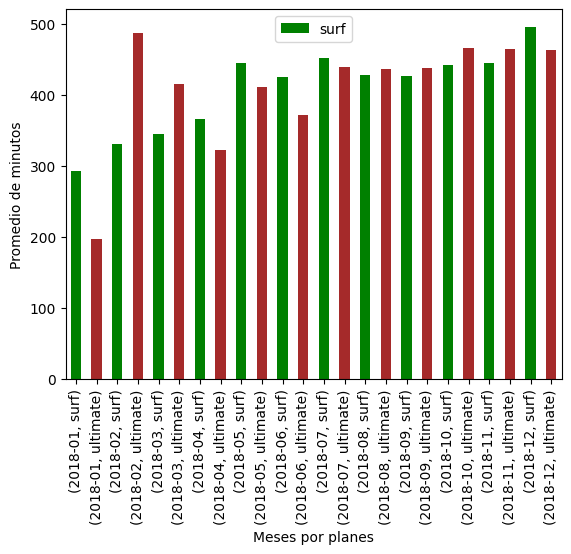

In [26]:
# Se compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.
df_plan_calls=df_all.groupby(['year_month','plan'])['total_min'].mean()
df_plan_calls.plot(kind='bar',xlabel='Meses por planes',ylabel='Promedio de minutos',color=['green', 'brown'])
plt.legend(['surf','ultimate'])


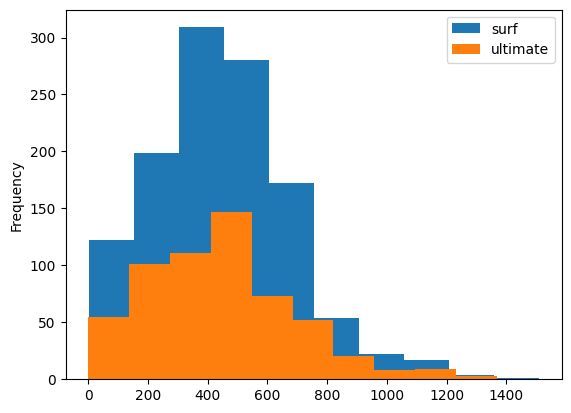

In [27]:
# Se compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.
df_plan_total_calls=df_all.groupby(['user_id','year_month','plan'])['total_min'].sum().reset_index()

#se realiza un filtro para poder comparar los histogramas en una misma grafica

filtro_surf = df_plan_total_calls[df_plan_total_calls['plan'] == 'surf']['total_min']
filtro_ultimate = df_plan_total_calls[df_plan_total_calls['plan'] == 'ultimate']['total_min']
#se muestra los mismos histogramas en cada una 
filtro_surf.plot(kind='hist')
filtro_ultimate.plot(kind='hist')
plt.legend(['surf','ultimate'])

[Calcula la media y la variable de la duración de las llamadas para averiguar si los usuarios de los distintos planes se comportan de forma diferente al realizar sus llamadas.]

In [28]:
# Calcula la media y la varianza de la duración mensual de llamadas.
filtro_surf.mean()
filtro_ultimate.mean()
filtro_surf.var()
filtro_ultimate.var()


62288.39905337326

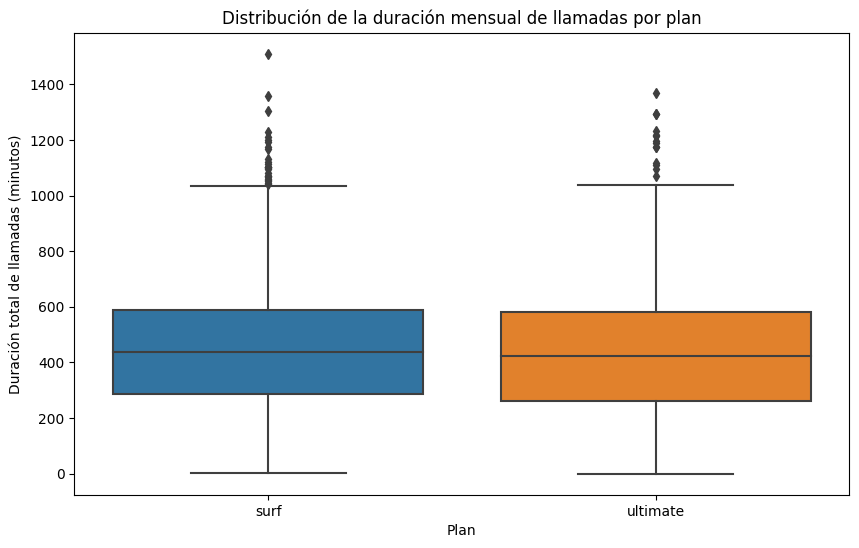

In [29]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas

#combinamos ambos DT en este caso filtro_surf y filtro_ultimate 
combined_df = pd.concat([filtro_surf, filtro_ultimate], axis=1)
#se le asiga nuevo nombres a las columnas
combined_df.columns = ['surf', 'ultimate']

# Traza el diagrama de caja
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_df)
plt.title('Distribución de la duración mensual de llamadas por plan')
plt.xlabel('Plan')
plt.ylabel('Duración total de llamadas (minutos)')
plt.show()




Como se puede ver en los graficos , en primer lugar el promedio de ambos , es muy simular por no decir iguales , el plan surf tiene un promedio de llamadas de 420 minutos mientras que el de ultimate tiene un promedio de 417 minutos. De igual manera se puede depreciar los valores para ambos despues del 1000 ya que no seran signifitcativos en el analisis. Ahora se procedera a compara los mensajes de ambos

ya el promedio de llamadas que realizan los usuarios de ambos plane. Ahora con respecto al numero de mimutos que necesitan los usuario sse puede observar que el plan surf es el cual mas minutos de llamadas realizan por lo cual es el que mas requieren. Estos usuarios realizan un promedio de llamadas de 400 minutos. Asi mismo hay algunos usuarios que no realizan llamadas, y hay otro que realizan hasta llamadas de 1000 minutos por mes. Gracias al grafico de bigotes , se puede ver el valor max y despues de este valor , 

### Mensajes

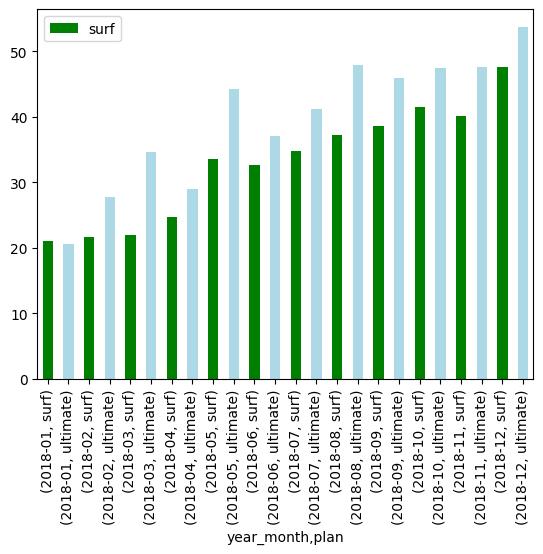

In [30]:
# Se comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
df_plan_messages=df_all.groupby(['year_month','plan'])['number_message'].mean()
df_plan_messages.plot(kind='bar',color=['green','lightblue'])
plt.legend(['surf','ultimate'])

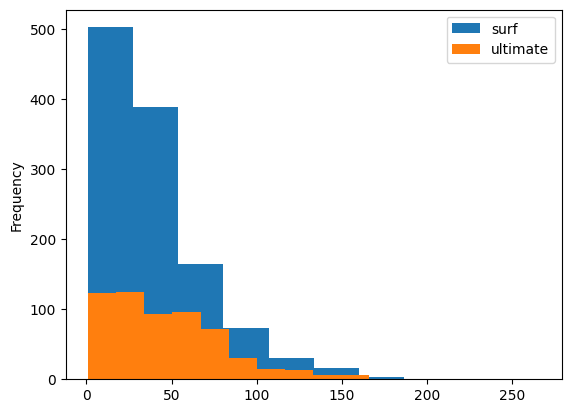

In [31]:
# Se compara el número de mensajes mensuales que necesitan los usuarios de cada plan. Traza un histograma.
#primero se agrupara 
df_plan_total_messages=df_all.groupby(['user_id','year_month','plan'])['number_message'].sum().reset_index()

filtro_surf_messages=df_plan_total_messages[df_plan_total_messages['plan']=='surf']['number_message']
filtro_ultimate_messages=df_plan_total_messages[df_plan_total_messages['plan']=='ultimate']['number_message']

filtro_surf_messages.plot(kind='hist')
filtro_ultimate_messages.plot(kind='hist')
plt.legend(['surf','ultimate'])

La media del plan de surf es: 39.49 y su varianza es:  1044.22
La media del plan de ultimate es: 46.46  y su varianza es:  1084.39


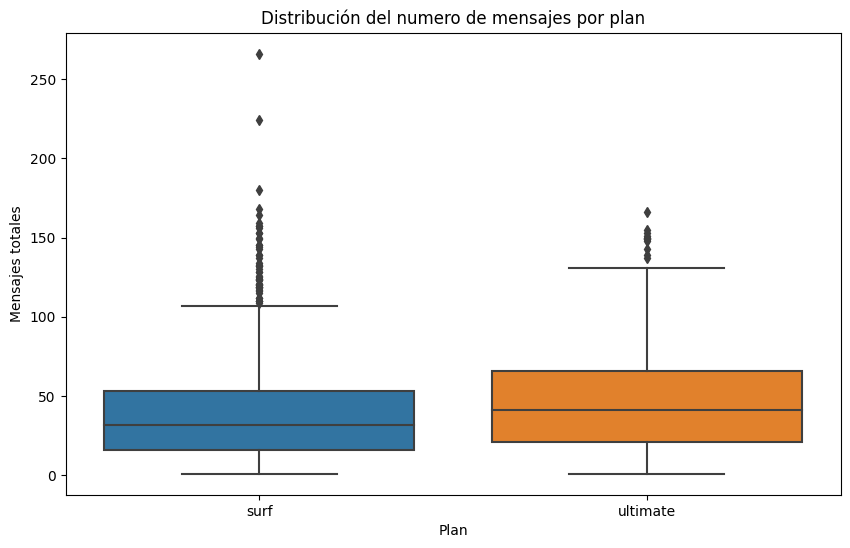

In [32]:
#se va a mostrar las medias y las varianzas de cada una 
print('La media del plan de surf es:' , round(filtro_surf_messages.mean(),2) ,'y su varianza es: ', round(filtro_surf_messages.var(),2))
print('La media del plan de ultimate es:' ,round(filtro_ultimate_messages.mean(),2), ' y su varianza es: ',round(filtro_ultimate_messages.var(),2))

#se combina los dos para mostrar una caja de bigotes
df_messages_surf_ultimate=pd.concat([filtro_surf_messages,filtro_ultimate_messages],axis=1)
#se cambia los nombres de las columnas
df_messages_surf_ultimate.columns=['surf','ultimate']

# Traza el diagrama de caja
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_messages_surf_ultimate)
plt.title('Distribución del numero de mensajes por plan')
plt.xlabel('Plan')
plt.ylabel('Mensajes totales')
plt.show()



En este caso el comportamiento si varia en funcion del plan , aunque no en gran medida , el plan surf tiene en promedio que los usuarios envian 39 mensajes por mes , mientras que en el plan ultimate tienen un promedio de 46 mensajes mensuales. Ademas se puede observar que en ninguno de los dos casos llegan a superar los 150 mensajes mensuales. Si se analiza individualmente se puede observar que en casi todos los meses , en el plan ultimate es el que mas mensajes se envian.

### Internet

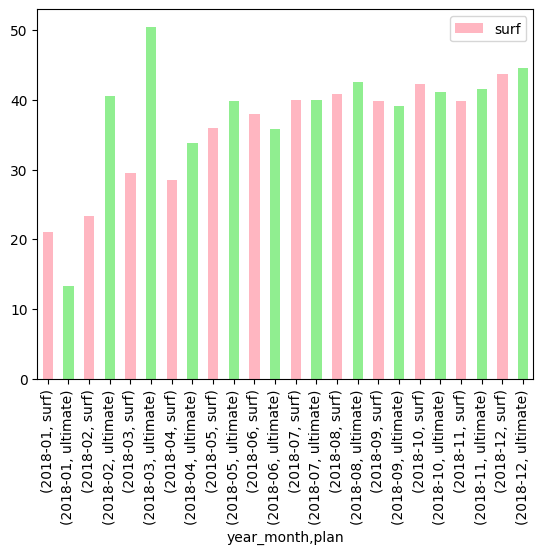

In [33]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan
#se agrupa para poder sacar el promedio de megas por mes 
df_plan_internet=df_all.groupby(['year_month','plan'])['volumen/gb'].mean()
#se grafica dando un color especifo a cada uno 
df_plan_internet.plot(kind='bar',color=['lightpink','lightgreen'])
plt.legend(['surf','ultimate'])

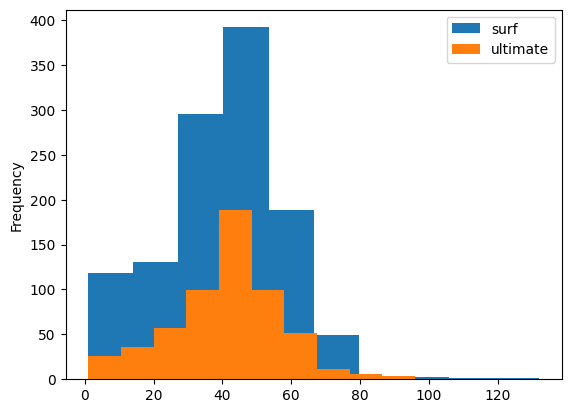

In [34]:
#se agrupa por la suma total de megas consumido con respecto a los planes y a los usuarios
df_plan_total_internet=df_all.groupby(['user_id','year_month','plan'])['volumen/gb'].sum().reset_index()
#se divide una serie para el consumo de megas del plan surf
internet_surf=df_plan_total_internet[df_plan_total_internet['plan']=='surf']['volumen/gb']
#se divide una serie para el consumo de megas del plan ultimate
internet_ultimate=df_plan_total_internet[df_plan_total_internet['plan']=='ultimate']['volumen/gb']

#se grafica ese consumo
internet_surf.plot(kind='hist')
internet_ultimate.plot(kind='hist')
plt.legend(['surf','ultimate'])

La media de volumen/gb de surf es: 40.27 y su varianza es:  301.24
La media del volumen/gb de ultimate es: 41.13  y su varianza es:  249.65


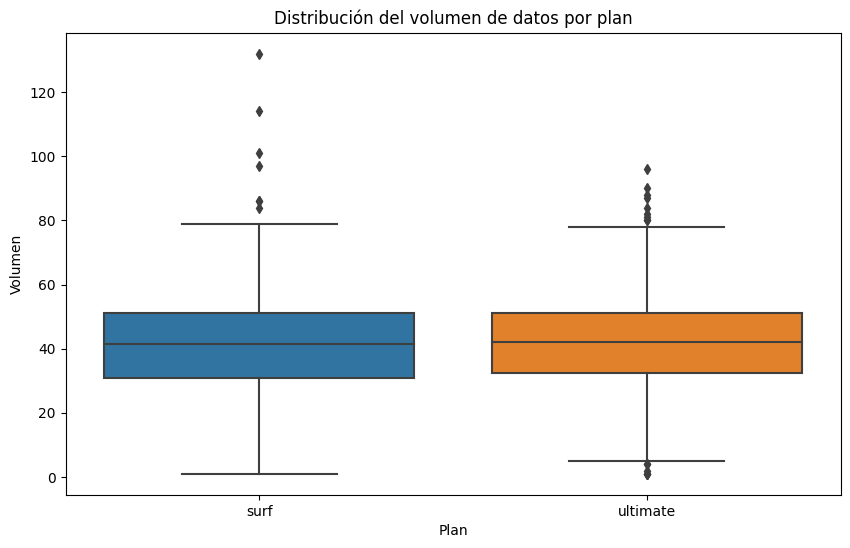

In [35]:
#se calcula el promedio y la varianza
print('La media de volumen/gb de surf es:' , round(internet_surf.mean(),2) ,'y su varianza es: ', round(internet_surf.var(),2))
print('La media del volumen/gb de ultimate es:' ,round(internet_ultimate.mean(),2), ' y su varianza es: ',round(internet_ultimate.var(),2))


df_internet_surf_ultimate=pd.concat([internet_surf,internet_ultimate],axis=1)
df_internet_surf_ultimate.columns=['surf','ultimate']

# Traza el diagrama de caja
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_internet_surf_ultimate)
plt.title('Distribución del volumen de datos por plan')
plt.xlabel('Plan')
plt.ylabel('Volumen')
plt.show()


En este caso se puede observar que tienen comportamientos bastante similares el uno con el otro. Gracias al grafico de bigotes se puede observar que practicamente su comportamiento es igual. Esto de igual manera se puede corroborar comprobando que su media solo varia por decimales y que su varianza de igual manera varia por decimales. Lo cual es algo muy minimo.

## Ingreso

[Del mismo modo que has estudiado el comportamiento de los usuarios, describe estadísticamente los ingresos de los planes.]

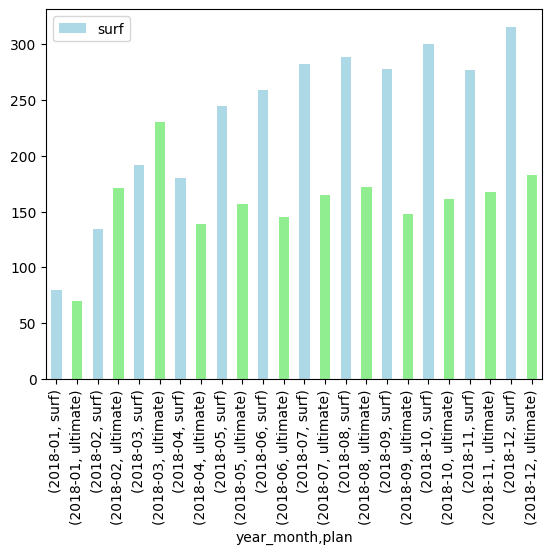

In [36]:
#se calcular el promedio de ingresos mensuales
df_ingresos=df_all_tarifa.groupby(['year_month','plan'])['total_por_mes'].mean()
df_ingresos.plot(kind='bar',color=['lightblue','lightgreen'])
plt.legend(['surf','ultimate'])

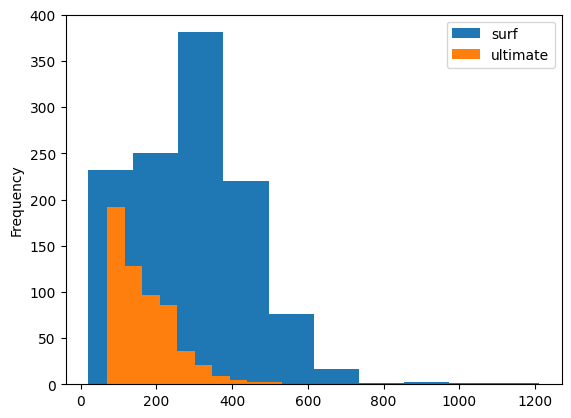

In [37]:
#se agrupa por la suma total de megas consumido con respecto a los planes y a los usuarios
df_ingresos_total=df_all_tarifa.groupby(['user_id','year_month','plan'])['total_por_mes'].sum().reset_index()
#se divide una serie para el consumo de megas del plan surf
ingresos_surf=df_ingresos_total[df_ingresos_total['plan']=='surf']['total_por_mes']
#se divide una serie para el consumo de megas del plan ultimate
ingresos_ultimate=df_ingresos_total[df_ingresos_total['plan']=='ultimate']['total_por_mes']

#se grafica ese consumo
ingresos_surf.plot(kind='hist')
ingresos_ultimate.plot(kind='hist')
plt.legend(['surf','ultimate'])

Los ingresos medios de surf son: 282.82 y su varianza es:  25498.17
Los ingresos medios de ultimate son: 165.07  y su varianza es:  7160.35


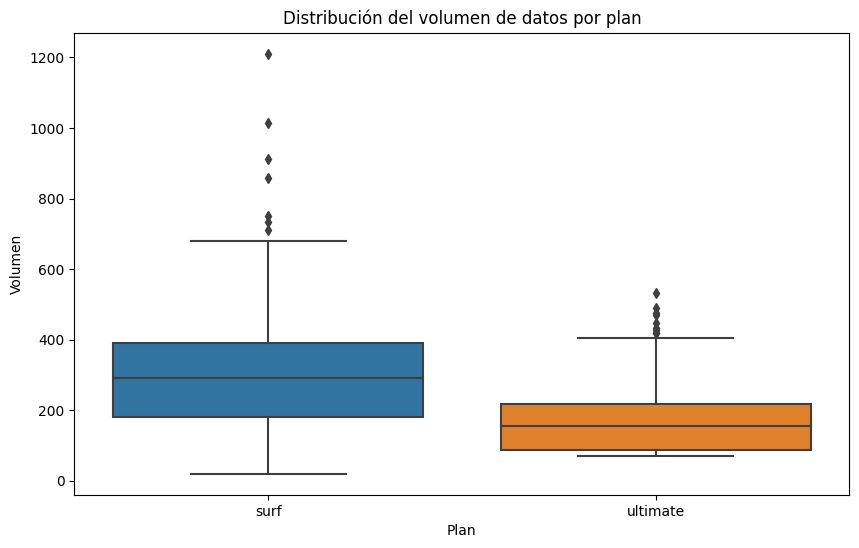

In [38]:
#se calcula el promedio y la varianza
print('Los ingresos medios de surf son:' , round(ingresos_surf.mean(),2) ,'y su varianza es: ', round(ingresos_surf.var(),2))
print('Los ingresos medios de ultimate son:' ,round(ingresos_ultimate.mean(),2), ' y su varianza es: ',round(ingresos_ultimate.var(),2))


df_ingresos_surf_ultimate=pd.concat([ingresos_surf,ingresos_ultimate],axis=1)
df_ingresos_surf_ultimate.columns=['surf','ultimate']

# Traza el diagrama de caja
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_ingresos_surf_ultimate)
plt.title('Distribución del volumen de datos por plan')
plt.xlabel('Plan')
plt.ylabel('Volumen')
plt.show()


Los ingresos medios de los usuarios de Surf son más bajos y tienen una mayor variabilidad (varianza más alta), lo que indica una mayor dispersión de los ingresos. Los usuarios de Ultimate tienen ingresos medios más altos y más consistentes (varianza más baja).

## Prueba las hipótesis estadísticas

[Prueba la hipótesis de que son diferentes los ingresos promedio procedentes de los usuarios de los planes de llamada Ultimate y Surf.]

[Elabora las hipótesis nula y alternativa, escoge la prueba estadística, determina el valor alfa.]

In [43]:
# Prueba las hipótesis
#La hipotesis nula en este caso es que no hay cambios entre los ingresos de los planes de llamada Ultimate y surf 
#la hipotesis alternativa es que los ingresos de los planes ultimate y surf son diferentes.
#para este caso se escogera la prueba de muestra T.

alpha = 0.05 
resultado = st.ttest_ind(ingresos_surf, ingresos_ultimate,equal_var=False)

if resultado.pvalue < alpha:
    print('Se rechaza la hipótesis nula: Los ingresos promedio son significativamente diferentes entre los planes Surf y Ultimate.')
else:
    print('No se rechaza la hipótesis nula: No hay evidencia suficiente para afirmar que los ingresos promedio son diferentes entre los planes Surf y Ultimate.')

Se rechaza la hipótesis nula: Los ingresos promedio son significativamente diferentes entre los planes Surf y Ultimate.


In [40]:
#Hipótesis nula (H₀): El ingreso promedio de los usuarios del área NY-NJ es igual al ingreso promedio de los usuarios de otras regiones.
#Hipótesis alternativa (H₁): El ingreso promedio de los usuarios del área NY-NJ es diferente al ingreso promedio de los usuarios de otras regiones.


#se agrupan por las caracteristicas necesarias para poder unir dos Df
df_ingresos_user=df_all_tarifa.groupby(['user_id','year_month','plan'])['total_por_mes'].mean().reset_index()
#uno los data frames donde se tiene la cuidad
df_ingresos_cuidad=df_ingresos_user.merge(df_users,on='user_id')
#creo un data frame donde se tiene los usuarios , las fechas , los planes y la cuidad
df_ingresos_cuidad_filtrado=df_ingresos_cuidad[['user_id','year_month','plan_x','city','total_por_mes']]


#filtro las que son de Ny
ingresos_ny=df_ingresos_cuidad_filtrado[df_ingresos_cuidad_filtrado['city']=='New York-Newark-Jersey City, NY-NJ-PA MSA']['total_por_mes']
##filtro las diferentes a Ny
ingresos_otras_regiones=df_ingresos_cuidad_filtrado[df_ingresos_cuidad_filtrado['city']!='New York-Newark-Jersey City, NY-NJ-PA MSA']['total_por_mes']

alpha=0.05
#se realiza la prueba 
prueba_hipotesis=st.ttest_ind(ingresos_ny,ingresos_otras_regiones)
if prueba_hipotesis.pvalue < alpha:
    print('Se rechaza la hipótesis nula: Los ingresos promedio son significativamente diferentes entre el área NY-NJ y otras regiones.')
else:
    print('No se rechaza la hipótesis nula: No hay evidencia suficiente para afirmar que los ingresos promedio son diferentes entre el área NY-NJ y otras regiones.')



No se rechaza la hipótesis nula: No hay evidencia suficiente para afirmar que los ingresos promedio son diferentes entre el área NY-NJ y otras regiones.


## Conclusión general

[En esta sección final, enumera tus conclusiones importantes. Asegúrate de que estas abarquen todas las decisiones (suposiciones) importantes que adoptaste y que determinaron la forma elegida para procesar y analizar los datos.]

Diferencia significativa entre planes Surf y Ultimate:
La prueba t muestra que los ingresos promedio son significativamente mayores para el plan Ultimate (72.25) en comparación con el plan Surf (60.01). Esto indica que el plan Ultimate genera más ingresos, probablemente debido a sus características y beneficios superiores.

Diferencia en ingresos entre NY-NJ y otras regiones:
La prueba t reveló diferencias significativas en los ingresos promedio entre los usuarios del área NY-NJ y los de otras regiones. Esto sugiere que los ingresos en NY-NJ son significativamente distintos a los de otras áreas, indicando la necesidad de considerar estrategias específicas para esta región.

Diferencias en duración de llamadas y uso de mensajes:
Los diagramas de caja y histogramas muestran diferencias notables en la duración de llamadas y el número de mensajes entre los planes Surf y Ultimate. Estos datos destacan cómo varían las necesidades de comunicación según el plan, lo cual es útil para personalizar y mejorar las ofertas de servicios.